# MLS wheat field demo

Notebook creator: Hannah Weiser, 2025

This demo uses a wheat field, built from 3D models of several wheat ears, which will be scanned by mobile laser scanning (MLS).

In [1]:
import helios
from helios.platforms import DynamicPlatformSettings  # these should not have to be imported extra?
from helios.settings import OutputFormat, LogVerbosity # these should not have to be imported extra?
import numpy as np

## Creating the virtual scene

In [2]:
# load objs and create transformations
groundplane = helios.ScenePart.from_obj("../data/sceneparts/basic/groundplane/groundplane.obj").scale(100)  # scale groundplane by 100
# positions for 15 wheat plants
wheat_positions = [
    [1.4, 2.8, 0.0],
    [1.4, 1.4, 0.0],
    [1.4, 0.0, 0.0],
    [1.4, -1.4, 0.0],
    [1.4, -2.8, 0.0],
    [0.0, 2.8, 0.0],
    [0.0, 1.4, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, -1.4, 0.0],
    [0.0, -2.8, 0.0],
    [-1.4, 2.8, 0.0],
    [-1.4, 1.4, 0.0],
    [-1.4, 0.0, 0.0],
    [-1.4, -1.4, 0.0],
    [-1.4, -2.8, 0.0],
]
sceneparts = [groundplane]
for pos in wheat_positions:
    w = helios.ScenePart.from_obj("../data/sceneparts/arbaro/wheat.obj", up_axis="y").scale(2).translate(pos)
    sceneparts.append(w)
# create scene
scene = helios.StaticScene(scene_parts=sceneparts)

## Platform and Scanner

In [3]:
from helios.scanner import riegl_vz_400
from helios.platforms import tractor

scanner = riegl_vz_400()
platform = tractor()

## Scanner Settings

In [4]:
# these scanner settings will be shared between all legs
scanner_settings = helios.ScannerSettings(pulse_frequency=100_000,  # Hz
                                          scan_frequency=50,  # Hz
                                          scan_angle=20,
                                          head_rotation=0,  # °/s
                                          trajectory_time_interval=0.05  # s
                                         )

## Survey Route

In [5]:
survey = helios.Survey(scanner=scanner, platform=platform, scene=scene)

In [6]:
waypoints = [
    [-10, -10, 0],
    [10, -10, 0],
    [10, 10, 0],
    [-10, 10, 0],
    [-10, -10, 0]
]
for x, y, z in waypoints:
    platform_settings = DynamicPlatformSettings(x=x, y=y, z=z, speed_m_s=3)
    leg = helios.Leg(scanner_settings=scanner_settings,
                    platform_settings=platform_settings)
    survey.add_leg(leg)

## Executing the survey

In [7]:
points, trajectories = survey.run(verbosity=LogVerbosity.VERBOSE, format=OutputFormat.NPY)

## Visualizing the results

In [8]:
import matplotlib.pyplot as plt

In [9]:
def extract_by_bb(arr, b_box):
    assert len(b_box) == 6
    x_min, y_min, z_min, x_max, y_max, z_max = b_box
    pos = arr["position"]
    subset = arr[
        (pos[:, 0] > x_min)
        & (pos[:, 0] < x_max)
        & (pos[:, 1] > y_min)
        & (pos[:, 1] < y_max)
        & (pos[:, 2] > z_min)
        & (pos[:, 2] < z_max)
    ]

    return subset

In [10]:
# create scene subset
bbox = [-5, -5, 0, 5, 5, 1.5]

points_sub = extract_by_bb(points, bbox)

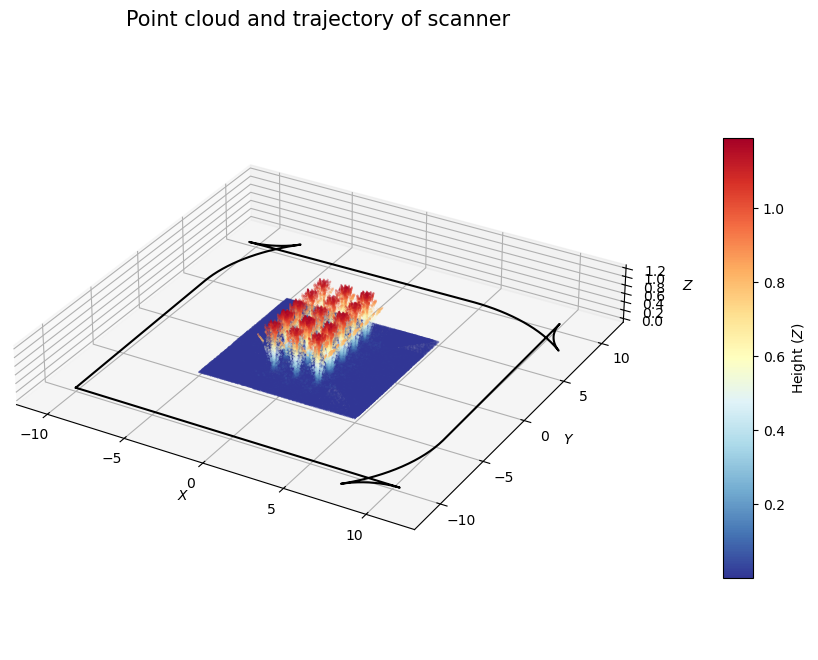

In [11]:
fig = plt.figure(figsize=(12, 8))
# 3d plot
ax = fig.add_subplot(projection="3d")

# scatter plot of points
pos = points_sub["position"]
sc = ax.scatter(
    pos[:, 0],
    pos[:, 1],
    pos[:, 2],
    c=pos[:, 2],
    cmap="RdYlBu_r",
    s=0.02,
    label="scene",
)

traj = trajectories["position"]
traj_time = trajectories["gps_time"]
# scatter plot of the trajectory
ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], c="black", label="scanner trajectory")

cax = plt.axes([0.85, 0.2, 0.025, 0.55])
cbar = plt.colorbar(sc, cax=cax)

cbar.set_label("Height ($Z$)")

# Add axis labels.
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_zlabel("$Z$")

# set equal axes
box = (bbox[3] - bbox[0], bbox[4] - bbox[1], bbox[5] - bbox[2])
ax.set_box_aspect(box)

# Set title.
ax.set_title(label="Point cloud and trajectory of scanner", fontsize=15)

# Display results
plt.show()